In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from fastai.vision.widgets import *

In [5]:
key = os.environ.get('AZURE_SEARCH_KEY', '6e54474808a24e80bec43b9261d7da31')

In [6]:
search_images_bing

<function fastbook.search_images_bing>

In [7]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#395) [Path('bears/grizzly/00000075.jpg'),Path('bears/grizzly/00000026.jpg'),Path('bears/grizzly/00000149.jpg'),Path('bears/grizzly/00000119.jpg'),Path('bears/grizzly/00000069.jpg'),Path('bears/grizzly/00000098.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000095.jpg'),Path('bears/grizzly/00000076.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
failed.map(Path.unlink);

In [13]:
??verify_images

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls=bears.dataloaders(path)

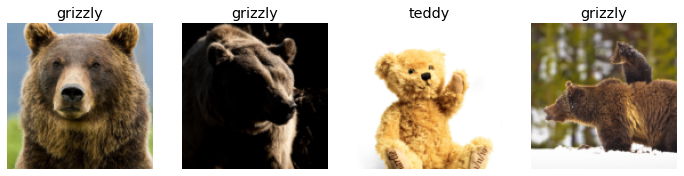

In [16]:
dls.valid.show_batch(max_n=4,nrows=1)

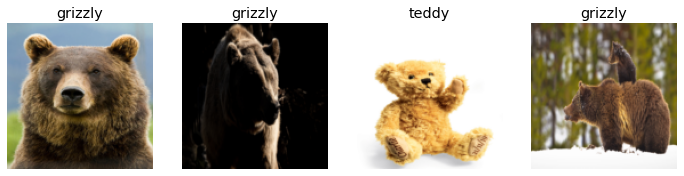

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

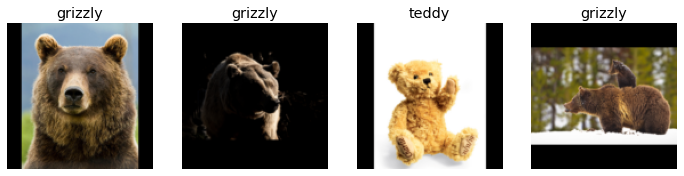

In [18]:
bears=bears.new(item_tfms=Resize(128,ResizeMethod.Pad,pad_mode='zeros'))
dls=bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

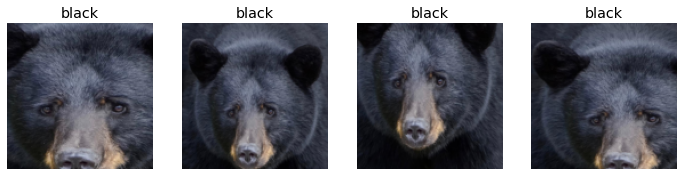

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

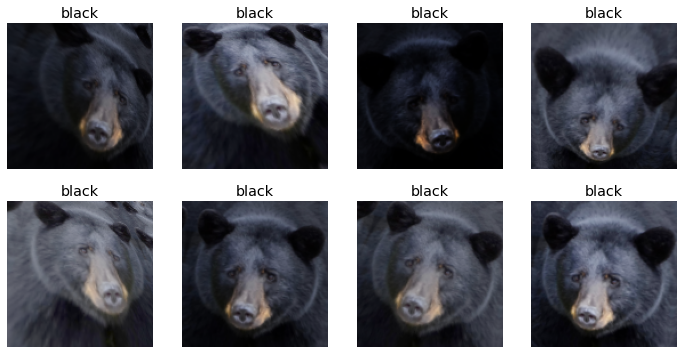

In [20]:
bears=bears.new(item_tfms=Resize(128),batch_tfms=aug_transforms(mult=2))
dls=bears.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2,unique=True)

In [21]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [22]:
learn=cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(4)

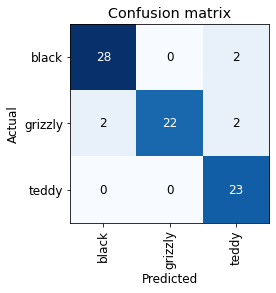

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

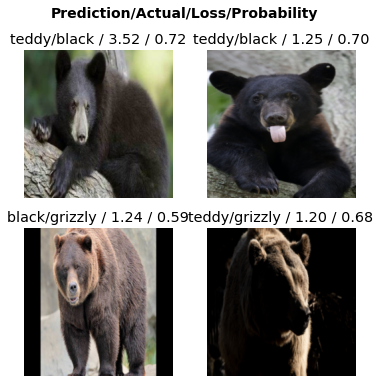

In [24]:
interp.plot_top_losses(4,nrows=2)

In [25]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [27]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [28]:
learn.export()

In [29]:
path=Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf=load_learner(path/'export.pkl')
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [31]:
btn_upload=widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [32]:
#btn_upload = SimpleNamespace(data = ['Grizzy.jpg'])

In [34]:
img = PILImage.create(btn_upload.data[-1])


In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [36]:
pred,pred_idx,probs = learn_inf.predict(img)

In [37]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.8896')

In [38]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [40]:
btn_upload = widgets.FileUpload()

In [41]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [42]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

  Using cached https://files.pythonhosted.org/packages/13/2f/acbe7006548f3914456ee47f97a2033b1b2f3daf921b12ac94105d87c163/nbconvert-6.0.7-py3-none-any.whl
ERROR: nbdev 1.1.13 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


FileUpload(value={}, description='Upload')

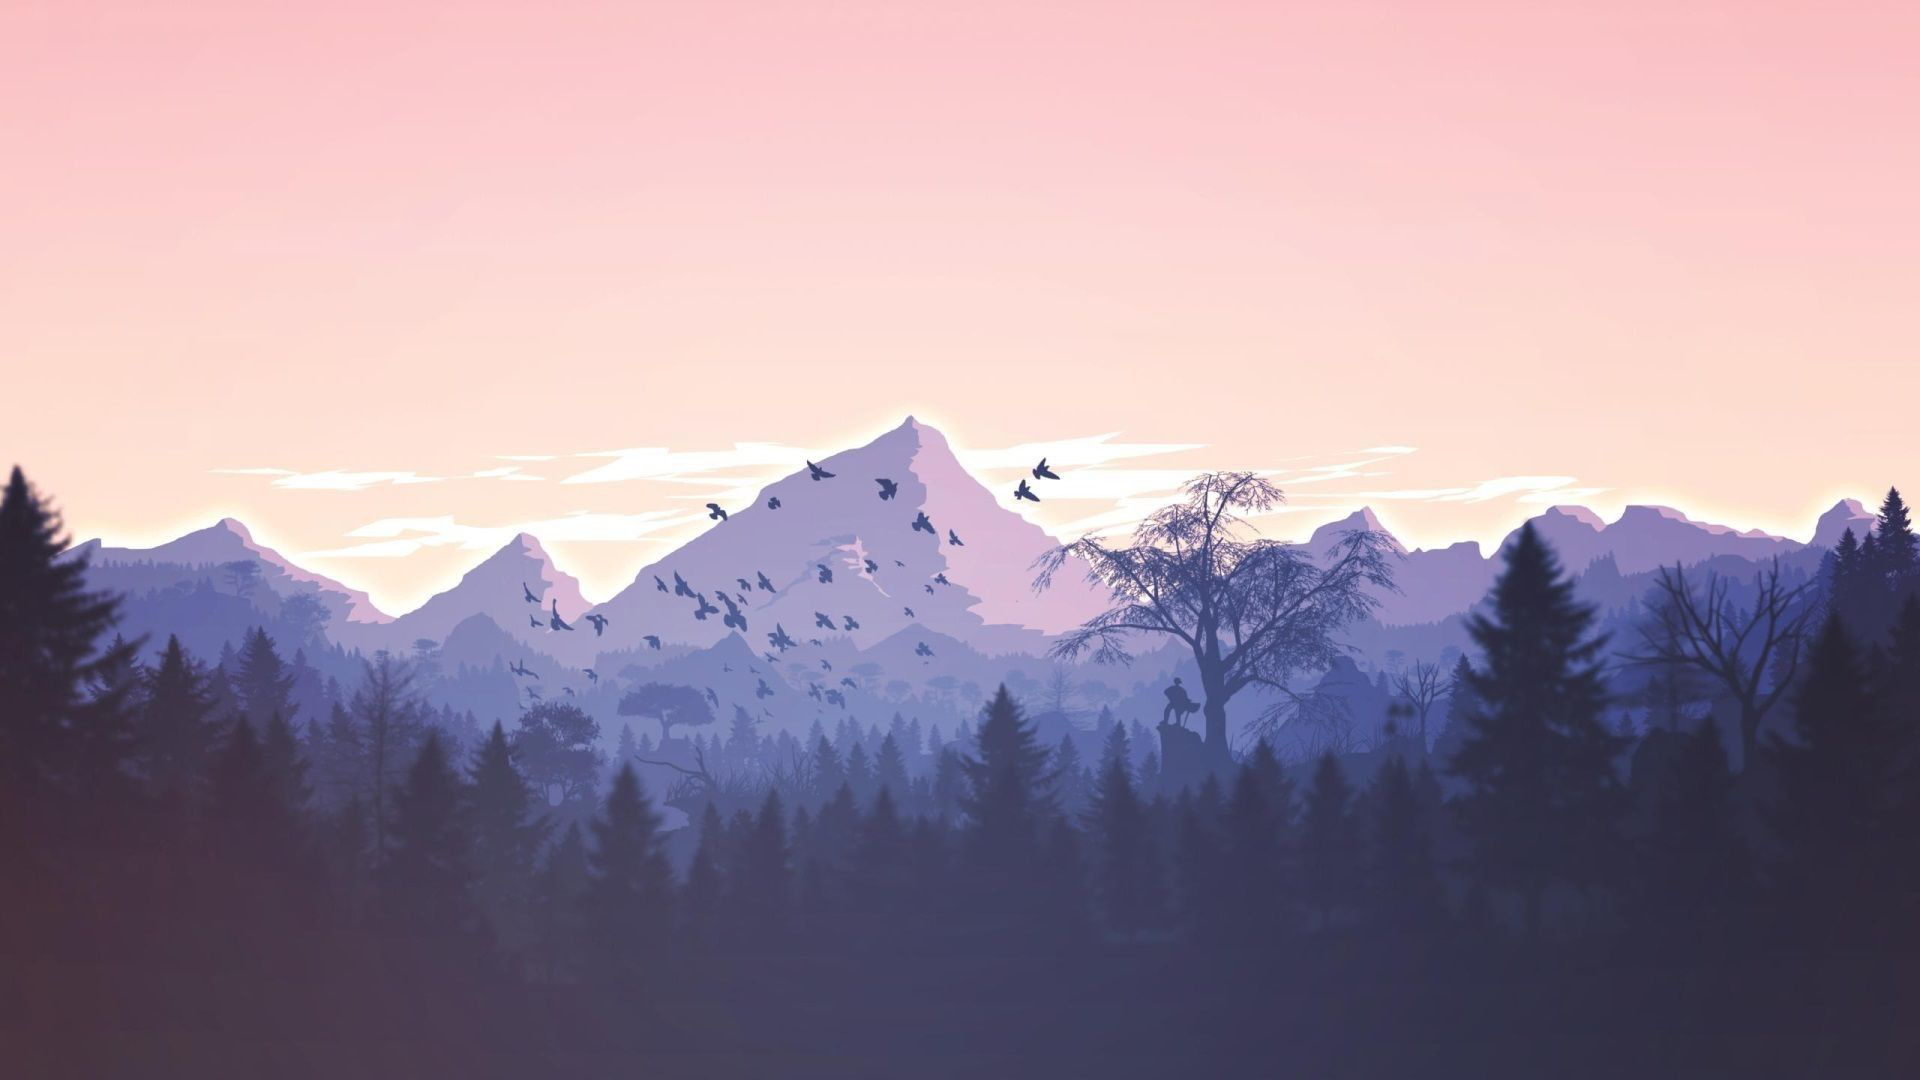

In [72]:
out_pl=widgets.Output()
#out_pl.clear_output()
out_pl

Output()

In [73]:
with out_pl:display(img.to_thumb(128,128))